/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


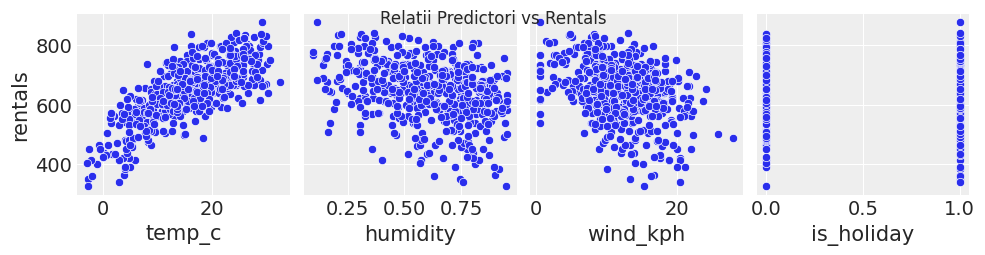

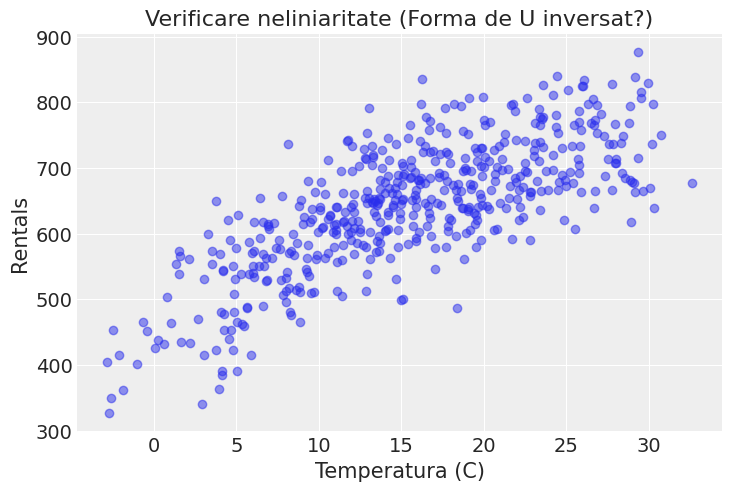

Datele au fost standardizate și pregătite.


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

az.style.use("arviz-darkgrid")

df=pd.read_csv('bike_daily.csv')

sns.pairplot(df, y_vars=['rentals'], x_vars=['temp_c','humidity', 'wind_kph','is_holiday'])
plt.suptitle("Relatii Predictori vs Rentals")
plt.show()

plt.scatter(df['temp_c'], df['rentals'], alpha=0.5)
plt.xlabel("Temperatura (C)")
plt.ylabel("Rentals")
plt.show()

vars_to_scale=['temp_c','humidity', 'wind_kph']
df_std = df.copy()

for col in vars_to_scale:
    mu = df[col].mean()
    sd = df[col].std()
    df_std[col] = (df[col] - mu) / sd

df_std['temp_c2'] = df_std['temp_c'] ** 2

season_idx, season_labels = pd.factorize(df['season'])
df_std['season_idx'] = season_idx
n_seasons = len(season_labels)
coords = {"season": season_labels, "obs_id": df.index}

print("Datele au fost standardizate")

In [ ]:
# --- Liniar ---
with pm.Model(coords=coords) as model_linear:
    t=pm.Data("t", df_std['temp_c'])
    h=pm.Data("h", df_std['humidity'])
    w=pm.Data("w", df_std['wind_kph'])
    hol=pm.Data("hol", df_std['is_holiday'])
    s_idx=pm.Data("s_idx", df_std['season_idx'])

    y_obs=df['rentals'].values

    alpha = pm.Normal("alpha", mu=y_obs.mean(), sigma=100)
    beta_temp = pm.Normal("beta_temp", mu=0, sigma=20)
    beta_hum = pm.Normal("beta_hum", mu=0, sigma=20)
    beta_wind = pm.Normal("beta_wind", mu=0, sigma=20)
    beta_hol=pm.Normal("beta_hol", mu=0, sigma=20)
    beta_season=pm.Normal("beta_season", mu=0, sigma=20, dims="season")

    sigma = pm.HalfNormal("sigma", sigma=100)

    mu = (alpha + beta_temp * t + beta_hum * h + beta_wind * w + beta_hol * hol + beta_season[s_idx])
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

    idata_linear = pm.sample(draws=1000, tune=1000, chains=2, return_inferencedata=True, log_likelihood=True)


# --- Polinomial (temp^2) ---
with pm.Model(coords=coords) as model_poly:

    t=pm.Data("t", df_std['temp_c'])
    t2=pm.Data("t2", df_std['temp_c2'])
    h=pm.Data("h", df_std['humidity'])
    w=pm.Data("w", df_std['wind_kph'])
    hol=pm.Data("hol", df_std['is_holiday'])
    s_idx=pm.Data("s_idx", df_std['season_idx'])

    y_obs=df['rentals'].values

    alpha=pm.Normal("alpha", mu=y_obs.mean(), sigma=100)
    beta_temp=pm.Normal("beta_temp", mu=0, sigma=20)
    beta_temp2=pm.Normal("beta_temp2", mu=0, sigma=10)
    beta_hum=pm.Normal("beta_hum", mu=0, sigma=20)
    beta_wind=pm.Normal("beta_wind", mu=0, sigma=20)
    beta_hol=pm.Normal("beta_hol", mu=0, sigma=20)
    beta_season=pm.Normal("beta_season", mu=0, sigma=20, dims="season")

    sigma = pm.HalfNormal("sigma", sigma=100)
    mu = (alpha + beta_temp * t + beta_temp2*t2 + beta_hum * h + beta_wind*w + beta_hol * hol + beta_season[s_idx])
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

    idata_poly=pm.sample(draws=1000, tune=1000, chains=2, return_inferencedata=True, log_likelihood=True)

Output()

Output()

In [ ]:
print("--- Rezultate model polinomial ---")
summary_poly = az.summary(idata_poly, var_names=["beta_temp", "beta_temp2", "beta_hum", "beta_wind"])
print(summary_poly)

--- Rezultate Model Polinomial ---
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_temp   50.619  3.377  44.612   56.944      0.084    0.069    1619.0   
beta_temp2 -14.516  1.964 -17.826  -10.461      0.042    0.047    2169.0   
beta_hum   -25.789  1.835 -29.198  -22.274      0.036    0.041    2557.0   
beta_wind  -31.349  1.930 -35.058  -27.850      0.044    0.049    1907.0   

            ess_tail  r_hat  
beta_temp     1437.0    1.0  
beta_temp2    1329.0    1.0  
beta_hum      1590.0    1.0  
beta_wind     1308.0    1.0  


In [ ]:
print("--- Rezultate model linear ---")
summary_poly = az.summary(idata_poly, var_names=["beta_temp", "beta_hum", "beta_wind", "beta_hol","beta_season"])
print(summary_poly)

--- Rezultate model linear ---
                       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_temp            50.619   3.377  44.612   56.944      0.084    0.069   
beta_hum            -25.789   1.835 -29.198  -22.274      0.036    0.041   
beta_wind           -31.349   1.930 -35.058  -27.850      0.044    0.049   
beta_hol            -34.588   3.562 -41.292  -27.684      0.075    0.091   
beta_season[winter] -34.964  10.856 -55.344  -14.653      0.427    0.239   
beta_season[spring]   2.274   9.981 -15.898   21.502      0.429    0.246   
beta_season[autumn]   7.748  10.102 -11.259   26.612      0.466    0.259   
beta_season[summer]  26.245  10.673   7.026   46.000      0.434    0.255   

                     ess_bulk  ess_tail  r_hat  
beta_temp              1619.0    1437.0    1.0  
beta_hum               2557.0    1590.0    1.0  
beta_wind              1907.0    1308.0    1.0  
beta_hol               2284.0    1071.0    1.0  
beta_season[winter]     644.0    1182.0

            rank    elpd_waic    p_waic  elpd_diff  weight         se  \
Polynomial     0 -2573.790703  9.466757   0.000000     1.0  15.814806   
Linear         1 -2600.677107  8.748328  26.886404     0.0  15.659465   

                 dse  warning scale  
Polynomial  0.000000    False   log  
Linear      6.927225    False   log  


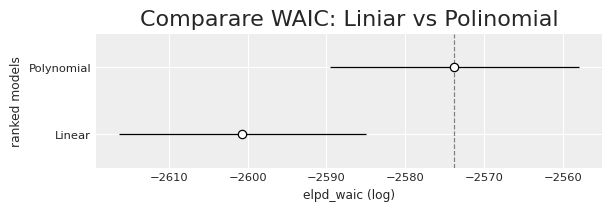

Generare grafic PPC...


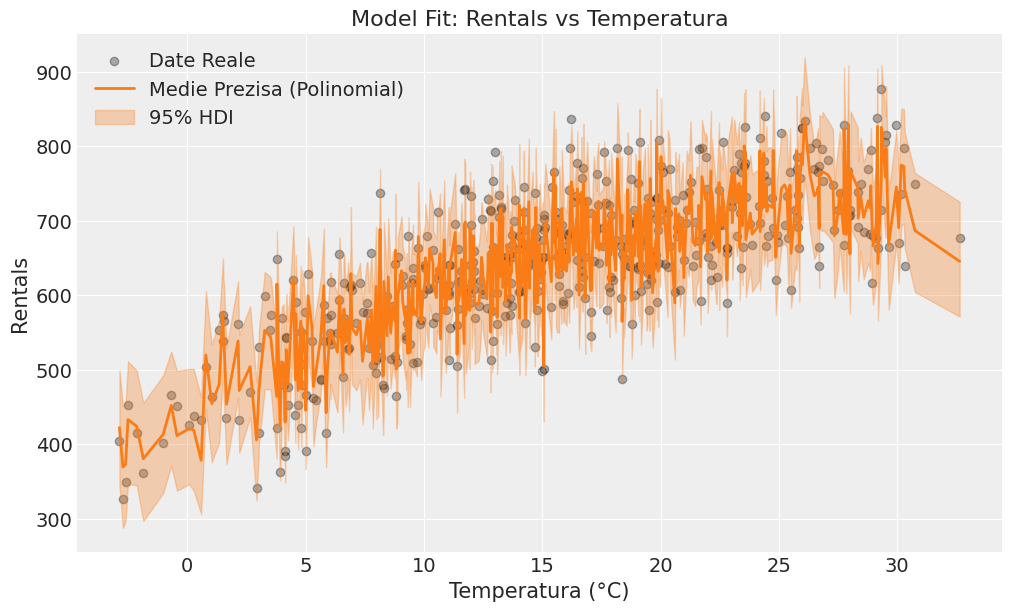

In [ ]:
# a) Comparare WAIC
cmp_df = az.compare({"Linear": idata_linear, "Polynomial": idata_poly}, ic="waic")
print(cmp_df)
az.plot_compare(cmp_df)
plt.title("Comparare WAIC: Liniar vs Polinomial")
plt.show()

# b) PPC vs Temperature
print("Generare grafic PPC...")
with model_poly:
    ppc = pm.sample_posterior_predictive(idata_poly, extend_inferencedata=True, progressbar=False)
post_mean_vals = ppc.posterior_predictive['y'].mean(dim=["chain", "draw"]).values
hdi_vals=az.hdi(ppc.posterior_predictive)['y'].values
temp_vals = df['temp_c'].values
sort_idx = np.argsort(temp_vals)
temp_sorted = temp_vals[sort_idx]
mean_sorted = post_mean_vals[sort_idx]

hdi_sorted=hdi_vals[sort_idx]
hdi_low = hdi_sorted[:, 0]
hdi_high = hdi_sorted[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['temp_c'], df['rentals'], color='k', alpha=0.3, label='Date Reale')
plt.plot(temp_sorted, mean_sorted, color='C1', linewidth=2, label='Medie Prezisa (Polinomial)')
plt.fill_between(temp_sorted, hdi_low, hdi_high, color='C1', alpha=0.3, label='95% HDI')

plt.xlabel("Temperatura")
plt.ylabel("Rentals")
plt.title("Model Fit: Rentals vs Temperatura")
plt.legend()
plt.show()

In [ ]:
Q = np.percentile(df['rentals'], 75)
is_high_demand=(df['rentals'] >= Q).astype(int)
print(f"Pragul Q (75%): {Q}")

with pm.Model(coords=coords) as model_logistic:
    t = pm.Data("t", df_std['temp_c'])
    t2 = pm.Data("t2", df_std['temp_c2'])
    h = pm.Data("h", df_std['humidity'])
    w = pm.Data("w", df_std['wind_kph'])
    hol = pm.Data("hol", df_std['is_holiday'])
    s_idx = pm.Data("s_idx", df_std['season_idx'])

    y_obs_binary = is_high_demand.values

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_temp = pm.Normal("beta_temp", mu=0, sigma=2)
    beta_temp2=pm.Normal("beta_temp2", mu=0, sigma=2)
    beta_hum = pm.Normal("beta_hum", mu=0, sigma=2)
    beta_wind = pm.Normal("beta_wind", mu=0, sigma=2)
    beta_hol = pm.Normal("beta_hol", mu=0, sigma=2)
    beta_season = pm.Normal("beta_season", mu=0, sigma=2, dims="season")

    mu=(alpha+beta_temp*t + beta_temp2*t2 + beta_hum*h + beta_wind*w + beta_hol*hol+beta_season[s_idx])

    p = pm.math.sigmoid(mu)
    y = pm.Bernoulli("y", p=p, observed=y_obs_binary)
    idata_logistic = pm.sample(draws=1000, tune=1000, chains=2, return_inferencedata=True)

print("\nRezultate Logistic (95% HDI):")
summary_log = az.summary(idata_logistic, var_names=["beta_temp", "beta_temp2","beta_hum", "beta_wind"], hdi_prob=0.95)
print(summary_log)

Pragul Q (75%): 708.0


Output()


Rezultate Logistic (95% HDI):
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_temp   1.754  0.403     0.975      2.516      0.012    0.008    1150.0   
beta_temp2 -0.554  0.250    -1.042     -0.082      0.007    0.005    1243.0   
beta_hum   -1.157  0.180    -1.501     -0.801      0.005    0.004    1589.0   
beta_wind  -1.396  0.188    -1.755     -1.046      0.005    0.004    1574.0   

            ess_tail  r_hat  
beta_temp     1231.0    1.0  
beta_temp2    1460.0    1.0  
beta_hum      1334.0    1.0  
beta_wind     1177.0    1.0  


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving bike_daily.csv to bike_daily (1).csv
